# Practical: Graph Neural Networks

In [ ]:
# For macOS (Apple Silicon) or Windows
!pip3 install torch torchvision torchaudio torch_geometric

In [3]:
from torch_geometric.datasets.qm9 import QM9

data = QM9(root='/tmp/QM9')
print(f"Data length: {len(data)}, Feature length: {data.num_features}, Target length: {data.num_classes}")


Data length: 130831, Feature length: 11, Target length: 19


In [ ]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool

from torch_geometric.datasets.qm9 import QM9

# Set the device
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('MPS (Apple Silicon GPU) is available')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available')
else:
    device = torch.device('cpu')
    print('CUDA and MPS are not available, CPU is used')

# Define a simple Graph Neural Network
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


# Split dataset (80% train, 10% val, 10% test)
train_dataset =data[:int(0.8 * len(data))]
val_dataset =data[int(0.8 * len(data)):int(0.9 * len(data))]
test_dataset =data[int(0.9 * len(data)):]


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True,num_workers=4, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True,num_workers=4, prefetch_factor=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True,num_workers=4, prefetch_factor=2)

model = GNN(input_dim=data.num_features, hidden_dim=64, output_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()


MPS (multi-process service) is available


In [2]:
# Training loop
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y[:, 0].unsqueeze(1))  # Predicting the first target (mu)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Validation loop
def evaluate(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            with torch.autocast(device='mps',dtype=torch.float16):
                data = data.to(device)
                output = model(data)
                loss = criterion(output, data.y[:, 0].unsqueeze(1))
                total_loss += loss.item()
    return total_loss / len(loader)

# Main training process
for epoch in range(50):
    train_loss = train()
    val_loss = evaluate(val_loader)
    print(f"Epoch {epoch + 1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Evaluate on the test set
test_loss = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}")

NameError: name 'model' is not defined

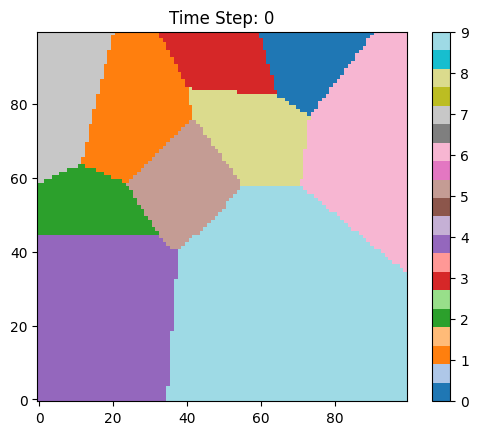

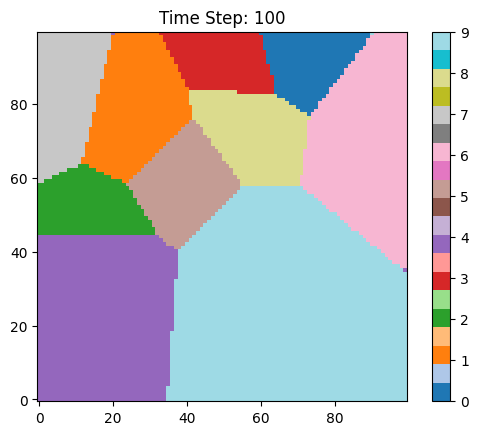

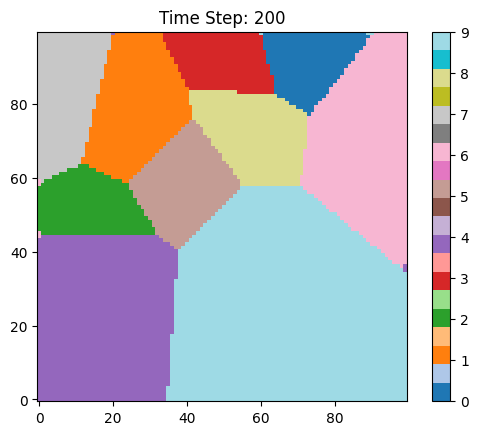

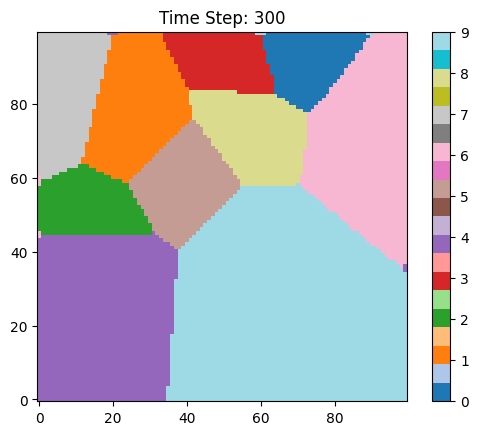

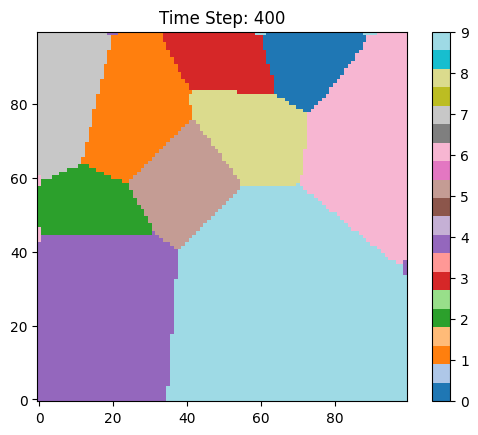

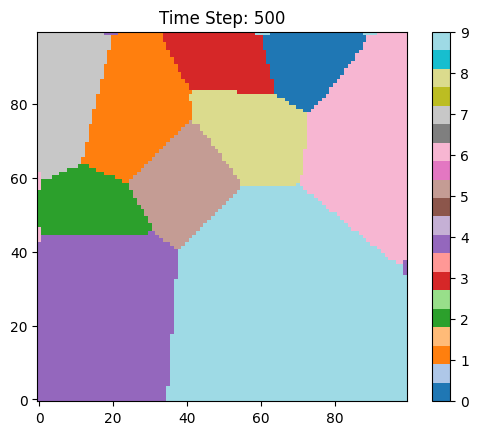

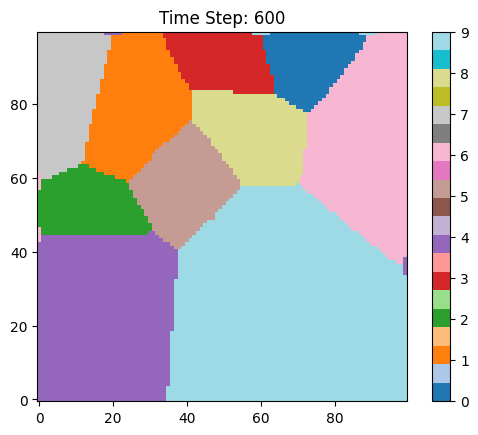

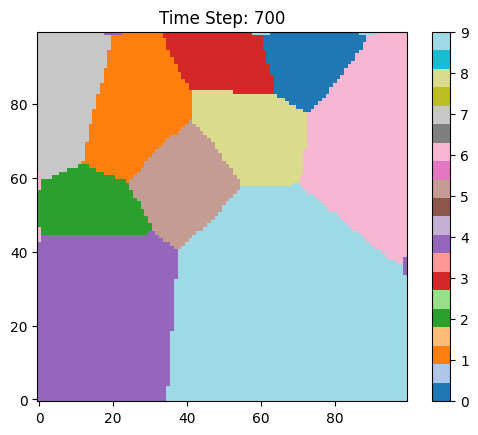

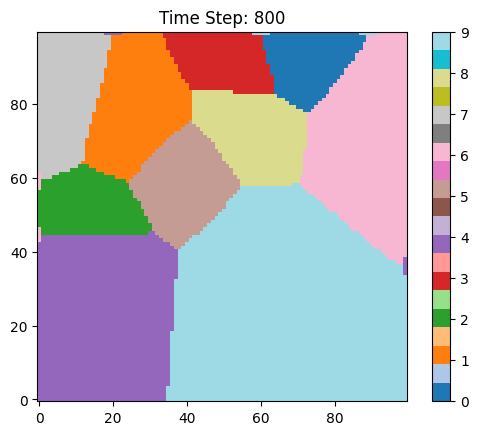

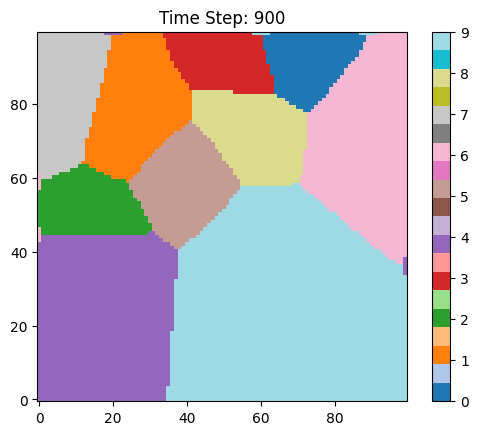

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
Nx, Ny = 100, 100  # Grid size
dx = dy = 1.0      # Grid spacing
dt = 0.1          # Time step (increased for faster evolution)
T = 1000          # Number of time steps

A = 1.0           # Double-well potential coefficient
kappa = 5.0       # Gradient energy coefficient (increased for smoother interfaces)
L = 5.0           # Mobility (increased for faster interface motion)
n_seeds = 10      # Number of Voronoi seeds

def laplacian(f):
    return (np.roll(f, 1, axis=0) + np.roll(f, -1, axis=0) +
            np.roll(f, 1, axis=1) + np.roll(f, -1, axis=1) - 4 * f) / (dx * dy)

# Initialize multiple phase fields with Voronoi seeds
phi = np.zeros((n_seeds, Nx, Ny))

# Random seed positions
seed_positions = np.random.randint(0, Nx, (n_seeds, 2))

for k, (sx, sy) in enumerate(seed_positions):
    for i in range(Nx):
        for j in range(Ny):
            distance = (i - sx) ** 2 + (j - sy) ** 2
            phi[k, i, j] = np.exp(-0.1 * distance)

# Normalize to ensure sum of all phases is 1
phi /= np.sum(phi, axis=0, keepdims=True)

# Time evolution loop
for t in range(T):
    lap_phi = np.array([laplacian(phi[k]) for k in range(n_seeds)])

    # Free energy derivatives and coupling term
    f_prime = A * phi * (phi - 1) * (phi + 1)
    coupling = 0.5 * (np.sum(phi, axis=0) - 1)

    # Update each phase field
    for k in range(n_seeds):
        phi[k] += dt * (-L * (f_prime[k] - kappa * lap_phi[k] - coupling))

    # Ensure positive values and renormalize
    phi = np.maximum(phi, 0)
    phi /= np.sum(phi, axis=0, keepdims=True)

    # Visualization
    if t % 100 == 0:
        plt.imshow(np.argmax(phi, axis=0), cmap='tab20', origin='lower')
        plt.title(f'Time Step: {t}')
        plt.colorbar()
        plt.pause(0.1)

plt.show()